# Corona Project 

Combining COVID 19 statistics with google search trends in Germany


Research questions:

*   Do people panic in those states with the highest number of COVID 19 cases?
*   What exactly are those people searching for on google?



Sources: 
* https://www.kaggle.com/headsortails/covid19-tracking-germany
* https://googletrends.github.io/data/

## Preparations

In [ ]:
# connect to google drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 
import datetime as dt
import itertools

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
sns.set_theme(style="whitegrid")

import csv
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

## Covid 19 Statistics

In [ ]:
# dataset official covid 19 statistics
df_covid_stat = pd.read_csv('/content/gdrive/My Drive/corona_project/covid_de.csv')

In [ ]:
df_covid_stat.head()

,state,county,age_group,gender,date,cases,deaths,recovered
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-18,1,0,0
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-22,1,0,0


In [ ]:
df_covid_stat.sort_values(by='date').head(10)

,state,county,age_group,gender,date,cases,deaths,recovered
86217,Brandenburg,LK Oberhavel,15-34,M,2020-01-21,1,0,1
45529,Bayern,LK Landsberg a.Lech,15-34,M,2020-01-28,1,0,1
59107,Bayern,LK Starnberg,35-59,M,2020-01-28,1,0,1
41629,Bayern,LK Fuerstenfeldbruck,15-34,M,2020-01-29,1,0,1
68625,Bayern,SK Muenchen,15-34,F,2020-01-29,1,0,1
41890,Bayern,LK Fuerstenfeldbruck,35-59,M,2020-01-31,1,0,1
60257,Bayern,LK Traunstein,00-04,F,2020-01-31,1,0,1
60637,Bayern,LK Traunstein,35-59,M,2020-01-31,1,0,1
68850,Bayern,SK Muenchen,15-34,M,2020-02-03,1,0,1
60266,Bayern,LK Traunstein,00-04,M,2020-02-04,1,0,1


#### Missing Values

In [ ]:
# Check for missing values
df_covid_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203830 entries, 0 to 203829
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   state      203830 non-null  object
 1   county     203830 non-null  object
 2   age_group  202992 non-null  object
 3   gender     201839 non-null  object
 4   date       203830 non-null  object
 5   cases      203830 non-null  int64 
 6   deaths     203830 non-null  int64 
 7   recovered  203830 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 12.4+ MB


In [ ]:
df_covid_stat['age_group'].value_counts().sort_values()

00-04     7915
05-14    17468
80-99    18194
60-79    36288
15-34    58625
35-59    64502
Name: age_group, dtype: int64

In [ ]:
df_covid_stat['gender'].value_counts().sort_values()

F    100471
M    101368
Name: gender, dtype: int64

In [ ]:
# Drop missing values
df_covid_stat.dropna(subset=['gender', 'age_group'], inplace=True)

In [ ]:
df_covid_stat.sort_values(by=['date', 'state'], inplace=True)
df_covid_stat.head(10)

,state,county,age_group,gender,date,cases,deaths,recovered
86217,Brandenburg,LK Oberhavel,15-34,M,2020-01-21,1,0,1
45529,Bayern,LK Landsberg a.Lech,15-34,M,2020-01-28,1,0,1
59107,Bayern,LK Starnberg,35-59,M,2020-01-28,1,0,1
41629,Bayern,LK Fuerstenfeldbruck,15-34,M,2020-01-29,1,0,1
68625,Bayern,SK Muenchen,15-34,F,2020-01-29,1,0,1
41890,Bayern,LK Fuerstenfeldbruck,35-59,M,2020-01-31,1,0,1
60257,Bayern,LK Traunstein,00-04,F,2020-01-31,1,0,1
60637,Bayern,LK Traunstein,35-59,M,2020-01-31,1,0,1
68850,Bayern,SK Muenchen,15-34,M,2020-02-03,1,0,1
45530,Bayern,LK Landsberg a.Lech,15-34,M,2020-02-04,1,0,1


In [ ]:
df_covid_stat.nunique()

state         16
county       412
age_group      6
gender         2
date         261
cases         94
deaths        12
recovered     63
dtype: int64

In [ ]:
# count cases per state, date and gender only and ignore county, age group and recovered (not relevant for this study)
df_covid_stat = df_covid_stat.groupby(by=['date', 'state', 'gender'])[['cases', 'deaths']].sum().reset_index()

In [ ]:
df_covid_stat.head()

,date,state,gender,cases,deaths
0,2020-01-21,Brandenburg,M,1,0
1,2020-01-28,Bayern,M,2,0
2,2020-01-29,Bayern,F,1,0
3,2020-01-29,Bayern,M,1,0
4,2020-01-31,Bayern,F,1,0


In [ ]:
# make sure cases is not 0 for male and female but 'deaths' > 0
df_covid_stat.query('deaths > 0 and cases == 0')

,date,state,gender,cases,deaths


#### Adding columns

In [ ]:
# combine info from 'gender' and 'cases' and add as seperate column
df_covid_stat['cases_male'] = 0
df_covid_stat['cases_female'] = 0
df_covid_stat['deaths_male'] = 0
df_covid_stat['deaths_female'] = 0

for i, g in enumerate(df_covid_stat['gender']):
  if g == 'M':
    df_covid_stat['cases_male'][i] = df_covid_stat['cases'][i]
    df_covid_stat['deaths_male'][i] = df_covid_stat['deaths'][i]
  else:
    df_covid_stat['cases_female'][i] = df_covid_stat['cases'][i]
    df_covid_stat['deaths_female'][i] = df_covid_stat['deaths'][i]


In [ ]:
# copy 'cases_male' to corresponding row with info of 'cases_female' (if any) and drop duplicated rows
df_covid_stat['duplicated'] = df_covid_stat.duplicated(subset=['date', 'state'], keep='first')

for i, d in enumerate(df_covid_stat['duplicated']):
  if d == True:
    df_covid_stat['cases_male'][i-1] = df_covid_stat['cases_male'][i]
    df_covid_stat['deaths_male'][i-1] = df_covid_stat['deaths_male'][i]

df_covid_stat = df_covid_stat.query('duplicated == False').reset_index(drop=True)

In [ ]:
# drop columns 'gender', 'deaths', 'cases' and 'duplicated' 
df_covid_stat.drop(columns=['gender', 'deaths', 'cases', 'duplicated'], inplace=True)

In [ ]:
# adding 'total_cases' and 'total_deaths'
df_covid_stat['total_cases'] = 0
df_covid_stat['total_deaths'] = 0

for i in range(len(df_covid_stat['date'])):
  df_covid_stat['total_cases'][i] = df_covid_stat['cases_male'][i] + df_covid_stat['cases_female'][i]
  df_covid_stat['total_deaths'][i] = df_covid_stat['deaths_male'][i] + df_covid_stat['deaths_female'][i]

In [ ]:
# adding month as seperate column
df_covid_stat['month'] = pd.DatetimeIndex(df_covid_stat['date']).month

# adding weekday column
df_covid_stat['weekday'] = pd.DatetimeIndex(df_covid_stat['date']).day_name()

In [ ]:
df_covid_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3764 entries, 0 to 3763
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           3764 non-null   object
 1   state          3764 non-null   object
 2   cases_male     3764 non-null   int64 
 3   cases_female   3764 non-null   int64 
 4   deaths_male    3764 non-null   int64 
 5   deaths_female  3764 non-null   int64 
 6   total_cases    3764 non-null   int64 
 7   total_deaths   3764 non-null   int64 
 8   month          3764 non-null   int64 
 9   weekday        3764 non-null   object
dtypes: int64(7), object(3)
memory usage: 294.2+ KB


In [ ]:
df_covid_stat.tail()

,date,state,cases_male,cases_female,deaths_male,deaths_female,total_cases,total_deaths,month,weekday
3759,2020-10-30,Saarland,19,24,0,0,43,0,10,Friday
3760,2020-10-30,Sachsen,54,69,0,0,123,0,10,Friday
3761,2020-10-30,Sachsen-Anhalt,54,65,0,0,119,0,10,Friday
3762,2020-10-30,Schleswig-Holstein,134,130,0,0,264,0,10,Friday
3763,2020-10-30,Thueringen,113,139,0,1,252,1,10,Friday


In [ ]:
# First and last day included
print('First day: ' + str(df_covid_stat['date'].min()))
print('Last day: ' + str(df_covid_stat['date'].max()))

First day: 2020-01-21
Last day: 2020-10-30


In [ ]:
df_covid_stat['date'] = pd.to_datetime(df_covid_stat['date'])

## Google Searches

In [ ]:
# dataset google searches March - June 2020
df_google_1 = pd.read_csv('/content/gdrive/My Drive/corona_project/google_mar_jun.csv')

# dataset google searches March - June 2020
df_google_2 = pd.read_csv('/content/gdrive/My Drive/corona_project/google_jul_oct.csv')
df_google_2.columns = df_google_2.iloc[0]
df_google_2.drop(df_google_2.index[0], inplace=True)
df_google_2.reset_index(drop=True, inplace=True)

In [ ]:
# Concatenate both google datasets
df_google = pd.concat([df_google_1, df_google_2], axis=1)

In [ ]:
df_google.head()

,2020-03-18 City,2020-03-18 Trending,2020-03-19 City,2020-03-19 Trending,2020-03-20 City,2020-03-20 Trending,2020-03-21 City,2020-03-21 Trending,2020-03-22 City,2020-03-22 Trending,2020-03-23 City,2020-03-23 Trending,2020-03-24 City,2020-03-24 Trending,2020-03-25 City,2020-03-25 Trending,2020-03-26 City,2020-03-26 Trending,2020-03-27 City,2020-03-27 Trending,2020-03-28 City,2020-03-28 Trending,2020-03-29 City,2020-03-29 Trending,2020-03-30 City,2020-03-30 Trending,2020-03-31 City,2020-03-31 Trending,2020-04-01 City,2020-04-01 Trending,2020-04-02 City,2020-04-02 Trending,2020-04-03 City,2020-04-03 Trending,2020-04-04 City,2020-04-04 Trending,2020-04-05 City,2020-04-05 Trending,2020-04-06 City,2020-04-06 Trending,2020-04-07 City,2020-04-07 Trending,2020-04-08 City,2020-04-08 Trending,2020-04-09 City,2020-04-09 Trending,2020-04-10 City,2020-04-10 Trending,2020-04-11 City,2020-04-11 Trending,2020-04-12 City,2020-04-12 Trending,2020-04-13 City,2020-04-13 Trending,2020-04-14 City,2020-04-14 Trending,2020-04-15 City,2020-04-15 Trending,2020-04-16 City,2020-04-16 Trending,2020-04-17 City,2020-04-17 Trending,2020-04-18 City,2020-04-18 Trending,2020-04-19 City,2020-04-19 Trending,2020-04-20 City,2020-04-20 Trending,2020-04-21 City,2020-04-21 Trending,2020-04-22 City,2020-04-22 Trending,2020-04-23 City,2020-04-23 Trending,2020-04-24 City,2020-04-24 Trending,2020-04-25 City,2020-04-25 Trending,2020-04-26 City,2020-04-26 Trending,2020-04-27 City,2020-04-27 Trending,2020-04-28 City,2020-04-28 Trending,2020-04-29 City,2020-04-29 Trending,2020-04-30 City,2020-04-30 Trending,2020-05-01 City,2020-05-01 Trending,2020-05-02 City,2020-05-02 Trending,2020-05-03 City,2020-05-03 Trending,2020-05-04 City,2020-05-04 Trending,2020-05-05 City,2020-05-05 Trending,2020-05-06 City,2020-05-06 Trending,2020-05-07 City,2020-05-07 Trending,2020-05-08 City,2020-05-08 Trending,2020-05-09 City,2020-05-09 Trending,2020-05-10 City,2020-05-10 Trending,2020-05-11 City,2020-05-11 Trending,2020-05-12 City,2020-05-12 Trending,2020-05-13 City,2020-05-13 Trending,2020-05-14 City,2020-05-14 Trending,2020-05-15 City,2020-05-15 Trending,2020-05-16 City,2020-05-16 Trending,2020-05-17 City,2020-05-17 Trending,2020-05-18 City,2020-05-18 Trending,2020-05-19 City,2020-05-19 Trending,2020-05-20 City,2020-05-20 Trending,2020-05-21 City,2020-05-21 Trending,2020-05-22 City,2020-05-22 Trending,2020-05-23 City,2020-05-23 Trending,2020-05-24 City,2020-05-24 Trending,2020-05-25 City,2020-05-25 Trending,2020-05-26 City,2020-05-26 Trending,2020-05-27 City,2020-05-27 Trending,2020-05-28 City,2020-05-28 Trending,2020-05-29 City,2020-05-29 Trending,2020-05-30 City,2020-05-30 Trending,2020-05-31 City,2020-05-31 Trending,2020-06-01 City,2020-06-01 Trending,2020-06-02 City,2020-06-02 Trending,2020-06-03 City,2020-06-03 Trending,2020-06-04 City,2020-06-04 Trending,2020-06-05 City,2020-06-05 Trending,2020-06-06 City,2020-06-06 Trending,2020-06-07 City,2020-06-07 Trending,2020-06-08 City,2020-06-08 Trending,2020-06-09 City,2020-06-09 Trending,2020-06-10 City,2020-06-10 Trending,2020-06-11 City,2020-06-11 Trending,2020-06-12 City,2020-06-12 Trending,2020-06-13 City,2020-06-13 Trending,2020-06-14 City,2020-06-14 Trending,2020-06-15 City,2020-06-15 Trending,2020-06-16 City,2020-06-16 Trending,2020-06-16 City.1,2020-06-16 Trending.1,2020-06-17 City,2020-06-17 Trending,2020-06-18 City,2020-06-18 Trending,2020-06-19 City,2020-06-19 Trending,2020-06-20 City,2020-06-20 Trending,2020-06-21 City,2020-06-21 Trending,2020-06-22 City,2020-06-22 Trending,2020-06-23 City,2020-06-23 Trending,2020-06-24 City,2020-06-24 Trending,2020-06-25 City,2020-06-25 Trending,2020-06-26 City,2020-06-26 Trending,2020-06-27 City,2020-06-27 Trending,2020-06-28 City,2020-06-28 Trending,2020-06-29 City,2020-06-29 Trending,2020-06-30 City,2020-06-30 Trending,2020-07-01 City,2020-07-01 Trending,2020-07-02 City,2020-07-02 Trending,2020-07-03 City,2020-07-03 Trending,2020-07-04 City,2020-07-04 Trending,2020-07-05 City,2020-07-05 Trending

The Google dataset includes trending topics and cities, which only share the same dates. To simplify further analysis this dataset will be split up into two parts:

*   df_google_trending
*   df_google_city

In [ ]:
# First and last day included
print('First day: ' + str(df_google.columns.min()))
print('Last day: ' + str(df_google.columns.max()))

First day: 2020-03-18  City
Last day: 2020-09-12  Trending


In [ ]:
# column "2020-06-16 City" and "2020-06-16 Trending" are duplicated
df_google.drop(['2020-06-16  City.1', '2020-06-16  Trending.1'], axis=1, inplace=True)

#### City Data

In [ ]:
# Transpose dataset and select only city information
df_google_city = df_google.transpose()[::2]

In [ ]:
df_google_city.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
2020-09-08 City,"Altdorf, Bavaria, Germany","Landshut, Bavaria, Germany","Moormerland, Lower Saxony, Germany","Memmingen, Bavaria, Germany","Würzburg, Bavaria, Germany","Meppen, Lower Saxony, Germany","Wietmarschen, Lower Saxony, Germany","Stade, Lower Saxony, Germany","Olching, Bavaria, Germany","Korschenbroich, North Rhine-Westphalia, Germany","Unterschleißheim, Bavaria, Germany","Lingen, Lower Saxony, Germany","Schwabach, Bavaria, Germany","Haltern am See, North Rhine-Westphalia, Germany","Erding, Bavaria, Germany","Weiden, Bavaria, Germany","Baden-Baden, Baden-Württemberg, Germany","Oberhausen, North Rhine-Westphalia, Germany","Bühl, Baden-Württemberg, Germany","Munich, Bavaria, Germany","Neumarkt in der Oberpfalz, Bavaria, Germany","Wunstorf, Lower Saxony, Germany","Leer, Lower Saxony, Germany","Bad Neustadt an der Saale, Bavaria, Germany","Delmenhorst, Lower Saxony, Germany","Herzogenrath, North Rhine-Westphalia, Germany","Rottweil, Baden-Württemberg, Germany","Dorsten, North Rhine-Westphalia, Germany","Bretten, Baden-Württemberg, Germany","Augsburg, Bavaria, Germany","Oldenburg, Lower Saxony, Germany","Bottrop, North Rhine-Westphalia, Germany","Wedemark, Lower Saxony, Germany","Ingolstadt, Bavaria, Germany","Korntal-Münchingen, Baden-Württemberg, Germany","Krefeld, North Rhine-Westphalia, Germany","Kehl, Baden-Württemberg, Germany","Nuremberg, Bavaria, Germany","Hagen, North Rhine-Westphalia, Germany","Mülheim, North Rhine-Westphalia, Germany","Kempten, Bavaria, Germany","Lünen, North Rhine-Westphalia, Germany","Aalen, Baden-Württemberg, Germany","Regensburg, Bavaria, Germany","Herne, North Rhine-Westphalia, Germany","Unna, North Rhine-Westphalia, Germany","Rastatt, Baden-Württemberg, Germany","Arnsberg, North Rhine-Westphalia, Germany","Bürstadt, Hesse, Germany","Ronnenberg, Lower Saxony, Germany","Norden, Lower Saxony, Germany","Steinfurt, North Rhine-Westphalia, Germany","Karlsruhe, Baden-Württemberg, Germany","Ravensburg, Baden-Württemberg, Germany","Dortmund, North Rhine-Westphalia, Germany","Kamp-Lintfort, North Rhine-Westphalia, Germany","Lehrte, Lower Saxony, Germany","Gladbeck, North Rhine-Westphalia, Germany","Ulm, Baden-Württemberg, Germany","Kaarst, North Rhine-Westphalia, Germany","Castrop-Rauxel, North Rhine-Westphalia, Germany","Fürth, Bavaria, Germany","Solingen, North Rhine-Westphalia, Germany","Neu-Ulm, Bavaria, Germany","Bergisch Gladbach, North Rhine-Westphalia, Ger...","Stuhr, Lower Saxony, Germany","Leverkusen, North Rhine-Westphalia, Germany","Konstanz, Baden-Württemberg, Germany","Warendorf, North Rhine-Westphalia, Germany","Heidelberg, Baden-Württemberg, Germany","Coburg, Bavaria, Germany","Bochum, North Rhine-Westphalia, Germany","Limburg, Hesse, Germany","Freiburg, Baden-Württemberg, Germany","Ansbach, Bavaria, Germany","Hamburg, Hamburg, Germany","Ingelheim am Rhein, Rhineland-Palatinate, Germany","Kassel, Hesse, Germany","Aschaffenburg, Bavaria, Germany","Bad Nauheim, Hesse, Germany","Gera, Thuringia, Germany","Bensheim, Hesse, Germany","Marl, North Rhine-Westphalia, Germany","Neuwied, Rhineland-Palatinate, Germany","Speyer, Rhineland-Palatinate, Germany","Mainz, Rhineland-Palatinate, Germany","Bayreuth, Bavaria, Germany","Erlangen, Bavaria, Germany","Koblenz, Rhineland-Palatinate, Germany","Neumünster, Schleswig-Holstein, Germany","Schwetzingen, Baden-Württemberg, Germany","Springe, Lower Saxony, Germany","Heidenheim, Baden-Württemberg, Germany","Tübingen, Baden-Württemberg, Germany","Velbert, North Rhine-Westphalia, Germany","Lüneburg, Lower Saxony, Germany","Rheine, North Rhine-Westphalia, Germany","Wiesbaden, Hesse, Germany","Biberach, Baden-Württemberg, Germany","Salzgitter, Lower Saxony, Germany"
202

In [ ]:
# unpivot dataframe
df_google_city = df_google_city.melt()

In [ ]:
df_google_city.head()

,variable,value
0,0,"Kleve, North Rhine-Westphalia, Germany"
1,0,"Kaufbeuren, Bavaria, Germany"
2,0,"Kaufbeuren, Bavaria, Germany"
3,0,"Kaufbeuren, Bavaria, Germany"
4,0,"Geilenkirchen, North Rhine-Westphalia, Germany"


In [ ]:
df_google_city.shape

(17900, 2)

In [ ]:
# adding column 'date' to the dataframe
df_google_city['date'] = 0

date = pd.date_range(start='03/18/2020', end='09/12/2020')

In [ ]:
# repeating time period 100 times to match each row to its corresponding day
i = 0
d = 0

while i <= 17900 and d < 100:
  for day in date:
    df_google_city['date'][i] = day
    i = i+1
  d = d+1

In [ ]:
# Double check by dates included in the dataframe
print('First day: ' + str(df_google_city['date'].min()))
print('Last day: ' + str(df_google_city['date'].max()))

print('\nUnique dates: ' + str(df_google_city['date'].nunique()))
print('\nCheck equal amount of days: \n' + str(df_google_city['date'].value_counts()))

First day: 2020-03-18 00:00:00
Last day: 2020-09-12 00:00:00

Unique dates: 179

Check equal amount of days: 
2020-07-21    100
2020-04-22    100
2020-04-15    100
2020-08-12    100
2020-03-19    100
             ... 
2020-07-03    100
2020-05-16    100
2020-07-07    100
2020-03-20    100
2020-08-23    100
Name: date, Length: 179, dtype: int64


In [ ]:
df_google_city.max()

variable                                        99
value       Überlingen, Baden-Württemberg, Germany
date                           2020-09-12 00:00:00
dtype: object

In [ ]:
df_google_city.tail()

,variable,value,date
17895,99,"Salzgitter, Lower Saxony, Germany",2020-09-08 00:00:00
17896,99,"Koblenz, Rhineland-Palatinate, Germany",2020-09-09 00:00:00
17897,99,"Herzogenrath, North Rhine-Westphalia, Germany",2020-09-10 00:00:00
17898,99,"Mannheim, Baden-Württemberg, Germany",2020-09-11 00:00:00
17899,99,"Langenfeld, North Rhine-Westphalia, Germany",2020-09-12 00:00:00


In [ ]:
# splitting column 'value' and adding locations separately
place = df_google_city['value'].str.split(", ", expand=True)

df_google_city['town'] = place[0]
df_google_city['county'] = place[1]
df_google_city['country'] = place[2]

df_google_city.drop(columns=['value', 'country'], inplace=True)

In [ ]:
# rename and order the dataframe
df_google_city.rename(columns={'variable': 'rank'}, inplace=True)
df_google_city = df_google_city[['date', 'rank', 'county', 'town']]

df_google_city.head()

,date,rank,county,town
0,2020-03-18 00:00:00,0,North Rhine-Westphalia,Kleve
1,2020-03-19 00:00:00,0,Bavaria,Kaufbeuren
2,2020-03-20 00:00:00,0,Bavaria,Kaufbeuren
3,2020-03-21 00:00:00,0,Bavaria,Kaufbeuren
4,2020-03-22 00:00:00,0,North Rhine-Westphalia,Geilenkirchen


In [ ]:
df_google_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17900 entries, 0 to 17899
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    17900 non-null  object
 1   rank    17900 non-null  int64 
 2   county  17900 non-null  object
 3   town    17900 non-null  object
dtypes: int64(1), object(3)
memory usage: 559.5+ KB


In [ ]:
df_google_city['county'].unique()

array(['North Rhine-Westphalia', 'Bavaria', 'Saxony', 'Lower Saxony',
       'Saxony-Anhalt', 'Baden-Württemberg', 'Thuringia',
       'Schleswig-Holstein', 'Rhineland-Palatinate', 'Hesse',
       'Brandenburg', 'Saarland', 'Mecklenburg-Vorpommern', 'ZZ-ZZZZ',
       'Hamburg', 'Bremen'], dtype=object)

In [ ]:
# Get state for 'ZZ-ZZZZ'
df_google_city.query('county == "ZZ-ZZZZ"')['town'].unique()

array(['Berlin (Germany)'], dtype=object)

In [ ]:
# replace English names with German names
dict_county = {'Baden-Württemberg':'Baden-Wuerttemberg',
                  'Bavaria':'Bayern',
                  'ZZ-ZZZZ':'Berlin',
                  'Hesse':'Hessen',
                  'Lower Saxony':'Niedersachsen',
                  'North Rhine-Westphalia':'Nordrhein-Westfalen',
                  'Rhineland-Palatinate':'Rheinland-Pfalz',
                  'Saxony':'Sachsen',
                  'Saxony-Anhalt':'Sachsen-Anhalt',
                  'Thuringia':'Thueringen'
                  }

df_google_city['state'] = df_google_city['county'].replace(dict_county)
df_google_city.drop(columns='county', inplace=True)

In [ ]:
# grouping by state
df_google_state = df_google_city.groupby(by=['date', 'state'])['rank'].count().reset_index()
df_google_state['places_top100_google'] = df_google_state['rank']
df_google_state.drop(columns='rank', inplace=True)
df_google_state

,date,state,places_top100_google
0,2020-03-18,Baden-Wuerttemberg,18
1,2020-03-18,Bayern,13
2,2020-03-18,Berlin,1
3,2020-03-18,Hessen,9
4,2020-03-18,Niedersachsen,3
...,...,...,...
2018,2020-09-12,Niedersachsen,18
2019,2020-09-12,Nordrhein-Westfalen,22
2020,2020-09-12,Rheinland-Pfalz,4
2021,2020-09-12,Saarland,1


In [ ]:
fig = px.line(
    df_google_state, 
    color = 'state', 
    x = 'date', 
    y = 'places_top100_google', 
    render_mode="svg"
)


fig.show()

#### Trending Data

In [ ]:
# exstracting trending key words in separate dataframe
df_google_trending = df_google[df_google.columns[1::2]]

# replacing column names with dates
date = pd.date_range(start='03/18/2020', end='09/12/2020')
df_google_trending.columns = date

In [ ]:
df_google_trending.head()

,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12
0,coronavirus news,coronavirus nrw,coronavirus bayern,coronavirus aktuell,coronavirus tipps,dax,banh mi,prinz charles,aktuelle zahlen coronavirus,coronavirus usa,coronavirus tipps,coronavirus tips,dax,koronawirus porady,andrew jack,wetter,coronavirus,coronavirus niedersachsen,dsds,boris johnson,boris johnson,coronavirus afrika,فيروس كورونا,fernsehprogramm heute,coronavirus türkei,frohe ostern,coronavirus china,coronavirus schule,coronavirus,coronavirus stats,coronavirus china,eurojackpot,corona deutschland,coronavirus stats,coronavirus sachsen anhalt,maskenpflicht nrw,robert koch institut coronavirus,norbert blüm,coronavirus masken,kim jong un,dax,coronavirus germania,schweden coronavirus,angela merkel coronavirus,tag der arbeit,coronavirus tips,reproduktionszahl coronavirus,fitnessstudios coronavirus,коронавирус,fitnessstudios coronavirus,coronavirus kinder kawasaki syndrom,lockerungen coronavirus,roy horn,reproduktionszahl coronavirus rki,reproduktionszahl coronavirus rki,nachrichten aktuell coronavirus,coronavirus china,reproduktionszahl coronavirus rki,bundesliga,bundesliga,heinsberg coronavirus,coronavirus corona rki fallzahlen,coronavirus r zahl aktuell,coronavirus corona,vatertag,dax,bundesliga,coronavirus nachrichten,nachrichten deutschland coronavirus,bundesliga,wetter,wetter,coronavirus dänemark,bundesliga,superspreader coronavirus,kindertag,wetter morgen,konjunkturpaket,rki fallzahlen coronavirus,schweden coronavirus,blutgruppen coronavirus,kinderbonus coronavirus,rki fallzahlen coronavirus,coronavirus thüringen,worldometers coronavirus,coronavirus italien,kinderbonus coronavirus,bundesliga,coronavirus china,corona app,coronavirus,coronavirus nrw,coronavirus italien,wirecard,sommer,stuttgart,tönnies coronavirus,coronavirus update,usa coronavirus,wirecard,coronavirus corona,bundesliga,2. bundesliga,coronavirus münchen,marsha p. johnson,worldometer coronavirus,coronavirus türkei,coronavirus aktuell deutschland,coronavirus kroatien,coronavirus spanien,coronavirus österreich,bolsonaro cor

In [ ]:
df_google_trending = df_google_trending.transpose().reset_index(drop=True)

In [ ]:
# save as csv file to create a wordcloud
# df_google_trending.to_csv('/content/gdrive/My Drive/corona_project/trending.csv', index=False, header=False, encoding='utf8')

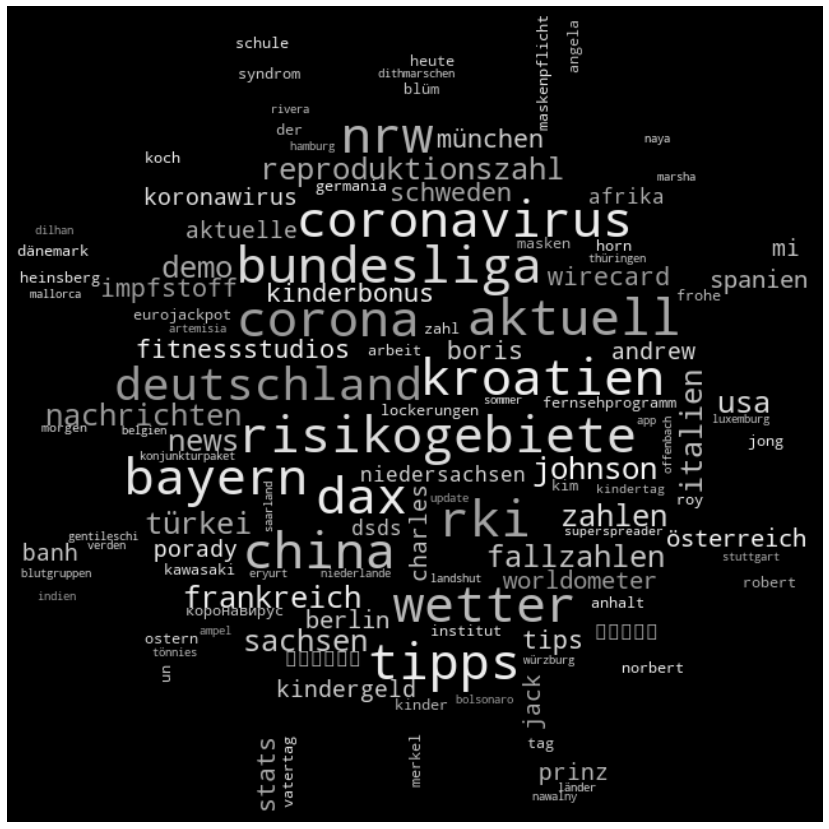

In [ ]:
# load trending dataset
trending = []
with open('/content/gdrive/My Drive/corona_project/trending.csv', 'rt') as f:
    reader = csv.reader(f)
    trending = '\t'.join([i[0] for i in reader])

# load image to add a shape to the wordcloud
virus_color = np.array(Image.open('/content/gdrive/My Drive/corona_project/corona_virus.png'))
# subsample by factor of 3
virus_color = virus_color[::3, ::3]

# create mask
virus_mask = virus_color.copy()
virus_mask[virus_mask.sum(axis=2) == 0] = 255

# enforce boundaries between colors
edges = np.mean([gaussian_gradient_magnitude(virus_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
virus_mask[edges > .08] = 255

# create wordcloud
wc = WordCloud(max_words=2000, mask=virus_mask, max_font_size=40, random_state=42, relative_scaling=0)
wc.generate(trending)

# create coloring 
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)
wc.recolor(color_func=grey_color_func)

# resize, turn off axis and save final picture
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear");
#wc.to_file('/content/gdrive/My Drive/corona_project/wordcloud_virus.png')


This wordcloud highlights popular COVID 19 related google searches. Most of them refer to locations such as countries (e.g. France, China and Germany), states (e.g. Bayern, Nordrhein-Westfalen, Sachsen) and risk areas in general. There are also a lot of keywords around news, number of cases and, of course, German football.

## Combining COVID 19 Statistics with Google City Data

#### Merging

In [ ]:
# combining df_covid_stat with df_state_count 
# line or bart chart combination?
df_covid_stat.head()

,date,state,cases_male,cases_female,deaths_male,deaths_female,total_cases,total_deaths,month,weekday
0,2020-01-21,Brandenburg,1,0,0,0,1,0,1,Tuesday
1,2020-01-28,Bayern,2,0,0,0,2,0,1,Tuesday
2,2020-01-29,Bayern,1,1,0,0,2,0,1,Wednesday
3,2020-01-31,Bayern,2,1,0,0,3,0,1,Friday
4,2020-02-03,Bayern,1,0,0,0,1,0,2,Monday


In [ ]:
df_google_state.head()

,date,state,places_top100_google
0,2020-03-18,Baden-Wuerttemberg,18
1,2020-03-18,Bayern,13
2,2020-03-18,Berlin,1
3,2020-03-18,Hessen,9
4,2020-03-18,Niedersachsen,3


In [ ]:
df_google_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023 entries, 0 to 2022
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  2023 non-null   datetime64[ns]
 1   state                 2023 non-null   object        
 2   places_top100_google  2023 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 47.5+ KB


In [ ]:
# use full outer join to combine both dataframes on date and state
df = df_google_state.merge(df_covid_stat, how='outer', on=['date', 'state'])

In [ ]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  3818 non-null   datetime64[ns]
 1   state                 3818 non-null   object        
 2   places_top100_google  2023 non-null   float64       
 3   cases_male            3764 non-null   float64       
 4   cases_female          3764 non-null   float64       
 5   deaths_male           3764 non-null   float64       
 6   deaths_female         3764 non-null   float64       
 7   total_cases           3764 non-null   float64       
 8   total_deaths          3764 non-null   float64       
 9   month                 3764 non-null   float64       
 10  weekday               3764 non-null   object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 357.9+ KB


In [ ]:
# replacing NaNs in latitude and longitude columns
df['lat'] = df['state'].replace(dict_state_lat)
df['long'] = df['state'].replace(dict_state_long)

In [ ]:
# replacing NaNs in month and weekday columns and adding a month numeric column
df['month_numeric'] = pd.DatetimeIndex(df['date']).month
df['month'] = pd.DatetimeIndex(df['date']).strftime("%B")

df['weekday'] = pd.DatetimeIndex(df['date']).day_name()

In [ ]:
# Remaining NaNs caused by zero cases on that certain day for the corresponding state
df.fillna(value=0, inplace=True)

#### Adding Columns

In [ ]:
# adding population per state 
# source: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Bevoelkerungsstand/Tabellen/bevoelkerung-nichtdeutsch-laender.html
dict_population = {'Baden-Wuerttemberg': 11100394,
                  'Bayern': 13124737,
                  'Berlin': 3669491,
                  'Brandenburg': 2521893,
                  'Bremen': 681202,
                  'Hamburg': 1847253,
                  'Hessen': 6288080,
                  'Mecklenburg-Vorpommern': 1608138,
                  'Niedersachsen': 7993608,
                  'Nordrhein-Westfalen': 17947221,
                  'Rheinland-Pfalz': 4093903,
                  'Saarland': 986887,
                  'Sachsen': 4071971,
                  'Sachsen-Anhalt': 2194782,
                  'Schleswig-Holstein': 2903773,
                  'Thueringen': 2133378
                  }

df['population'] = df['state'].replace(dict_population)

In [ ]:
# adding number of mid and large cities per state
# source: https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9F-_und_Mittelst%C3%A4dte_in_Deutschland
dict_number_cities = {'Baden-Wuerttemberg': 104,
                      'Bayern': 75,
                      'Berlin': 1,
                      'Brandenburg': 27,
                      'Bremen': 2,
                      'Hamburg': 1,
                      'Hessen': 59,
                      'Mecklenburg-Vorpommern': 9,
                      'Niedersachsen': 92,
                      'Nordrhein-Westfalen': 209,
                      'Rheinland-Pfalz': 22,
                      'Saarland': 9,
                      'Sachsen': 25,
                      'Sachsen-Anhalt': 24,
                      'Schleswig-Holstein': 22,
                      'Thueringen': 21
                      }

df['number_cities'] = df['state'].replace(dict_number_cities)

In [ ]:
# adding state area in square kilometers 
# source: https://de.statista.com/statistik/daten/studie/154868/umfrage/flaeche-der-deutschen-bundeslaender/
dict_area_km = {'Baden-Wuerttemberg': 35748,
                'Bayern': 70542,
                'Berlin': 891,
                'Brandenburg': 29654,
                'Bremen': 419,
                'Hamburg': 755,
                'Hessen': 21116,
                'Mecklenburg-Vorpommern': 23295,
                'Niedersachsen': 47710,
                'Nordrhein-Westfalen': 34112,
                'Rheinland-Pfalz': 19858,
                'Saarland': 2571,
                'Sachsen': 18450,
                'Sachsen-Anhalt': 20457,
                'Schleswig-Holstein': 15801,
                'Thueringen': 16202
                }

df['area_km'] = df['state'].replace(dict_area_km)

In [ ]:
# adding population per square kilometer
df['pop_per_km'] = [round(df['population'][i] / df['area_km'][i]) for i in range(len(df['population']))]

In [ ]:
df.sort_values(by='date', inplace=True)
df.head()

,date,state,places_top100_google,cases_male,cases_female,deaths_male,deaths_female,total_cases,total_deaths,month,weekday,lat,long,month_numeric,population,number_cities,area_km,pop_per_km
2023,2020-01-21,Brandenburg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,January,Tuesday,52.392110,13.056937,1,2521893,27,29654,85.0
2024,2020-01-28,Bayern,0.0,2.0,0.0,0.0,0.0,2.0,0.0,January,Tuesday,48.135876,11.575480,1,13124737,75,70542,186.0
2025,2020-01-29,Bayern,0.0,1.0,1.0,0.0,0.0,2.0,0.0,January,Wednesday,48.135876,11.575480,1,13124737,75,70542,186.0
2026,2020-01-31,Bayern,0.0,2.0,1.0,0.0,0.0,3.0,0.0,January,Friday,48.135876,11.575480,1,13124737,75,70542,186.0
2027,2020-02-03,Bayern,0.0,1.0,0.0,0.0,0.0,1.0,0.0,February,Monday,48.135876,11.575480,2,13124737,75,70542,186.0


In [ ]:
df['date'].max()

Timestamp('2020-10-30 00:00:00')

In [ ]:
df['cases_per_10000'] = df['total_cases'] / df['population'] * 10000

In [ ]:
df['relative_google_searches'] = df['places_top100_google'] / df['number_cities'] 

In [ ]:
df.columns

Index(['date', 'state', 'places_top100_google', 'cases_male', 'cases_female',
       'deaths_male', 'deaths_female', 'total_cases', 'total_deaths', 'month',
       'weekday', 'lat', 'long', 'month_numeric', 'population',
       'number_cities', 'area_km', 'pop_per_km', 'cases_per_10000',
       'relative_google_searches'],
      dtype='object')

#### Analysis and Plots

In [ ]:
# plot total cases over time by state
fig = px.line(
    df, 
    color = 'state', 
    x = 'date', 
    y = 'total_cases', 
    range_x = ['2020-18-03','2020-10-30'],
    render_mode="png",
    labels={
        'date':'Date',
        'total_cases': 'Total Cases'
            },
    title='Development COVID 19 cases per state'
)

fig.update_layout(
    autosize=False,
    width=1900,
    height=800,)

fig.show()

Above plot clearly reveals differences among the states. Also quite interesting are those drops in numbers every couple days. In Germany, the Robert Koch Institut collects numbers of COVID 19 cases and those get slightly delayed by weekends. 

In [ ]:
# group by month and state
df_state_month = df.groupby(by=['month_numeric', 'month', 'state', 'population', 'number_cities', 'area_km', 'pop_per_km'])[['places_top100_google', 'cases_male', 'cases_female', 'deaths_male', 'deaths_female', 'total_cases', 'total_deaths', 'cases_per_10000', 'relative_google_searches']].sum().reset_index()
df_state_month.head()

,month_numeric,month,state,population,number_cities,area_km,pop_per_km,places_top100_google,cases_male,cases_female,deaths_male,deaths_female,total_cases,total_deaths,cases_per_10000,relative_google_searches
0,1,January,Bayern,13124737,75,70542,186.0,0.0,5.0,2.0,0.0,0.0,7.0,0.0,0.005333,0.0
1,1,January,Brandenburg,2521893,27,29654,85.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.003965,0.0
2,2,February,Baden-Wuerttemberg,11100394,104,35748,311.0,0.0,13.0,6.0,0.0,0.0,19.0,0.0,0.017117,0.0
3,2,February,Bayern,13124737,75,70542,186.0,0.0,11.0,3.0,0.0,0.0,14.0,0.0,0.010667,0.0
4,2,February,Hamburg,1847253,1,755,2447.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.005413,0.0


In [ ]:
fig = px.bar(df_state_month, x='state', y='total_cases', color='month', title='Total Cases Overview', labels={'total_cases':'Total Cases', 'state': 'State'})
fig.update_layout(barmode='group')
fig.show()

Using a bar plot instead of a line plot allows comparing months and states in a much easier way. Important to think about: states might be very different in population, structure and size. This could have a huge impact on the figures we see here. 

In [ ]:
# plotting total deaths over time per state
fig = px.bar(df_state_month, x='state', y='total_deaths', color='month', title='Total Deaths Overview', labels={'total_deaths':'Total Deaths', 'state': 'State'})
fig.update_layout(barmode='group')
fig.show()

Total number of deaths is quite high in March/ April and got much lower during summer time. As total cases went also down in summer, this might have caused very low COVID 19 related deaths. Worth thinking about: Did we already have a high number of COVID 19 cases in January and February, which we didn't know about? Those patients died in March got infected some time ahead.  

In [ ]:
# differences in population per state
fig = px.bar(df_state_month, x='state', y='population', title='Population per State', labels={'population':'Population', 'state': 'State'})
fig.show()


As stated above we can clearly see huge differences in states. It might be a good idea to see how the distribution changes when considering cases per 10 000 people. 

In [ ]:
# comparing total COVID 19 cases with cities listed on google top 100
fig = px.scatter(df_state_month[df_state_month['month_numeric'].isin([3, 4, 5, 6, 7, 8, 9])], x='month', y='total_cases', size='places_top100_google', color="state", size_max=20, range_y=[0, 27000], 
                 labels={
                     'total_cases': 'Total COVID 19 Cases',
                     'month': 'Month',
                     'state': 'State',
                     'places_top100_google': 'Cities listed in top 100 COVID 19 google searches'
                 },
                 #title='Development of COVID 19 cases and related google searches per state'
                 )

fig.update_layout(
    autosize=False,
    width=700,
    height=500
)

fig.show()


This bubble chart makes it easy to see how COVID 19 cases and google search figures of each state changed over time. On the y-axis you find again the total number of COVID 19 cases for each state per month. The bubble size stands for the number of cities a state got on the top 100 list of COVID 19 related google searches.

In [ ]:
fig = px.scatter(df_state_month[df_state_month['month_numeric'].isin([3, 4, 5, 6, 7, 8, 9])], x='month', y='cases_per_10000', size='relative_google_searches', color="state", range_y=[0, 20], size_max=20,
                 labels={
                     'cases_per_10000': 'Cases per 10 000 people',
                     'month': 'Month',
                     'state': 'State',
                     'relative_google_searches': 'Relative google searches'
                 },
                 #title='Development of COVID 19 cases and related google searches per state'
                 )

fig.update_layout(
    autosize=False,
    width=700,
    height=500
)


fig.show()

Absolute numbers got replaced by cases per 10 000 people. To make the bubble size more informative , the previous numbers have been divided by the amount of cities per state.

In [ ]:
df.sort_values(by='month_numeric').head(10)

,date,state,places_top100_google,cases_male,cases_female,deaths_male,deaths_female,total_cases,total_deaths,month,weekday,lat,long,month_numeric,population,number_cities,area_km,pop_per_km,cases_per_10000,relative_google_searches
2023,2020-01-21,Brandenburg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,January,Tuesday,52.392110,13.056937,1,2521893,27,29654,85.0,0.003965,0.0
2024,2020-01-28,Bayern,0.0,2.0,0.0,0.0,0.0,2.0,0.0,January,Tuesday,48.135876,11.575480,1,13124737,75,70542,186.0,0.001524,0.0
2025,2020-01-29,Bayern,0.0,1.0,1.0,0.0,0.0,2.0,0.0,January,Wednesday,48.135876,11.575480,1,13124737,75,70542,186.0,0.001524,0.0
2026,2020-01-31,Bayern,0.0,2.0,1.0,0.0,0.0,3.0,0.0,January,Friday,48.135876,11.575480,1,13124737,75,70542,186.0,0.002286,0.0
2043,2020-02-27,Saarland,0.0,0.0,1.0,0.0,0.0,1.0,0.0,February,Thursday,49.239067,7.001077,2,986887,9,2571,384.0,0.010133,0.0
2044,2020-02-28,Baden-Wuerttemberg,0.0,6.0,1.0,0.0,0.0,7.0,0.0,February,Friday,49.113576,9.185454,2,11100394,104,35748,311.0,0.006306,0.0
2045,2020-02-28,Bayern,0.0,2.0,0.0,0.0,0.0,2.0,0.0,February,Friday,48.135876,11.575480,2,13124737,75,70542,186.0,0.001524,0.0
2046,2020-02-28,Hessen,0.0,0.0,1.0,0.0,0.0,1.0,0.0,February,Friday,50.104622,8.210930,2,6288080,59,21116,298.0,0.001590,0.0
2047,2020-02-28,Nordrhein-Westfalen,0.0,14.0,21.0,0.0,0.0,35.0,0.0,February,Friday,51.228975,6.777957,2,17947221,209,34112,526.0,0.019502,0.0
2048,2020-02-28,Rheinland-Pfalz,0.0,1.0,0.0,0.0,0.0,1.0,0.0,February,Friday,49.985805,7.331352,2,4093903,22,19858,206.0,0.002443,0.0


In [ ]:
df_state_month.head()

,month_numeric,month,state,population,number_cities,area_km,pop_per_km,places_top100_google,cases_male,cases_female,deaths_male,deaths_female,total_cases,total_deaths,cases_per_10000,relative_google_searches
0,1,January,Bayern,13124737,75,70542,186.0,0.0,5.0,2.0,0.0,0.0,7.0,0.0,0.005333,0.0
1,1,January,Brandenburg,2521893,27,29654,85.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.003965,0.0
2,2,February,Baden-Wuerttemberg,11100394,104,35748,311.0,0.0,13.0,6.0,0.0,0.0,19.0,0.0,0.017117,0.0
3,2,February,Bayern,13124737,75,70542,186.0,0.0,11.0,3.0,0.0,0.0,14.0,0.0,0.010667,0.0
4,2,February,Hamburg,1847253,1,755,2447.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.005413,0.0


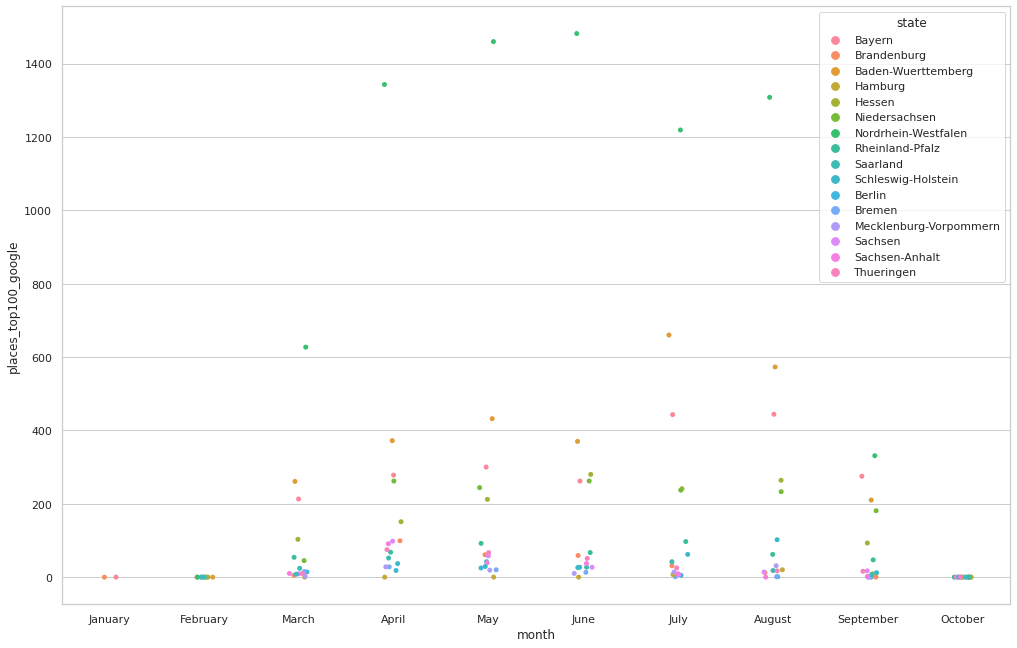

In [ ]:
# changing y-axis: places_top100_google instead of COVID 19 figures
fig = plt.gcf()
fig.set_size_inches(17, 11)

sns.set_theme(style="whitegrid")
ax = sns.stripplot(x="month", y="places_top100_google", hue="state", data=df_state_month)


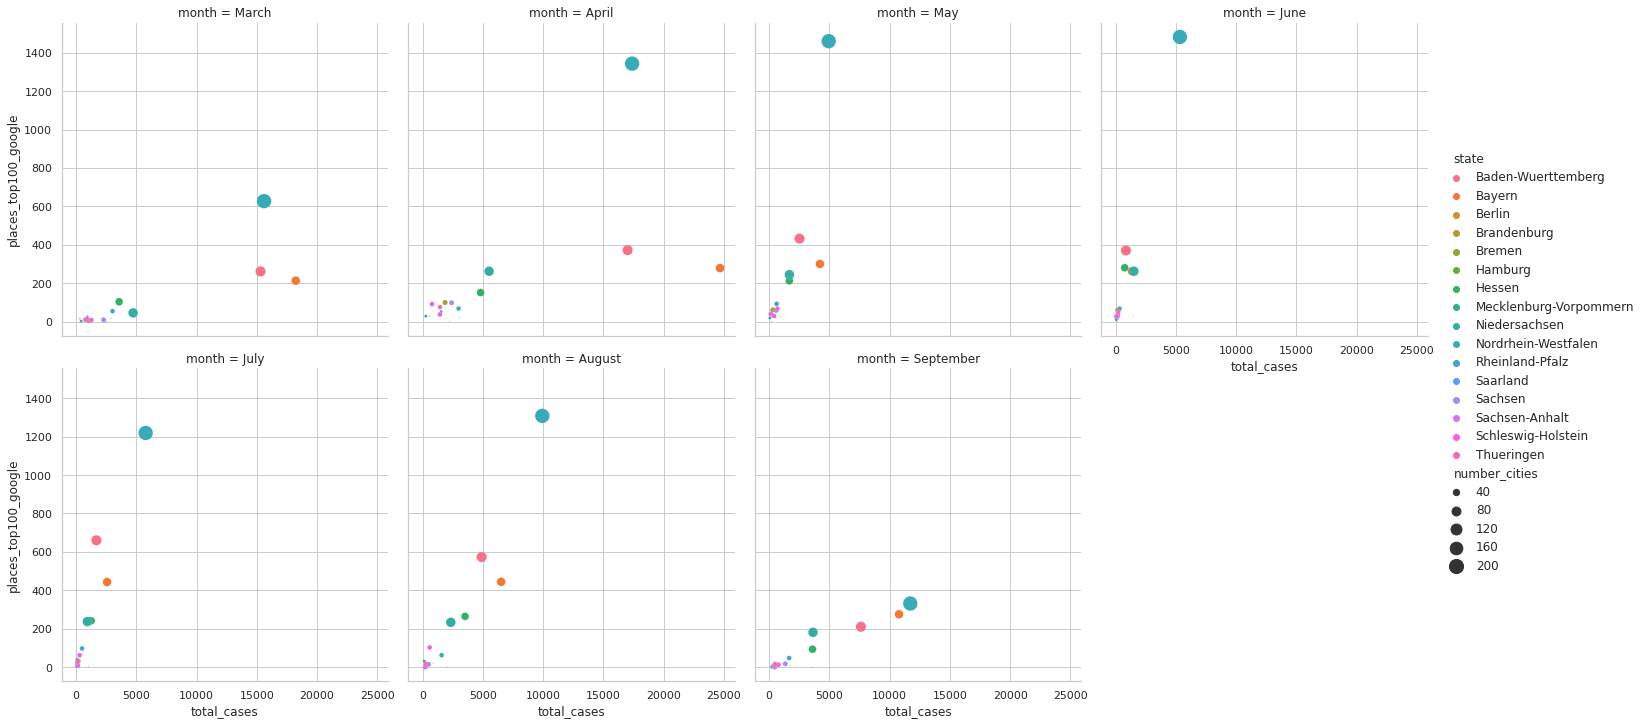

In [ ]:
# adding number of cities
minsize = min(df_state_month['number_cities'])
maxsize = max(df_state_month['number_cities'])
g = sns.relplot(
    data=df_state_month.query('2 < month_numeric < 10'),
    x="total_cases", y="places_top100_google",
    hue="state", size="number_cities", sizes=(minsize, maxsize),
    col='month', col_wrap=4
)

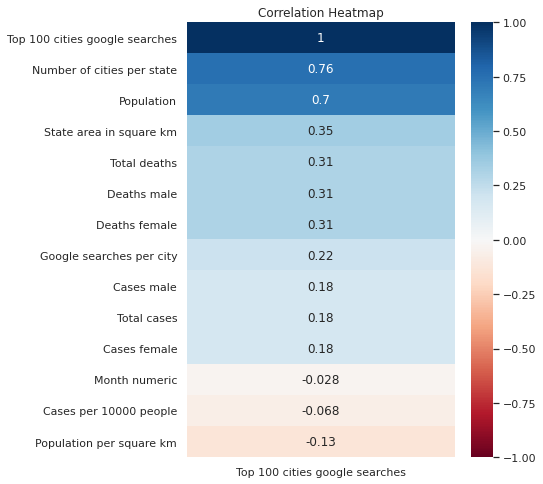

In [ ]:
y_axis_labels = ['Top 100 cities google searches', 'Number of cities per state', 'Population', 'State area in square km', 'Total deaths', 'Deaths male', 'Deaths female', 'Google searches per city', 'Cases male', 'Total cases', 'Cases female', 'Month numeric', 'Cases per 10000 people', 'Population per square km']
x_axis_label = ['Top 100 cities google searches']

fig = plt.gcf()
fig.set_size_inches(6, 8)
ax = plt.axes()

sns_heatmap = sns.heatmap(df_state_month.corr().sort_values(by='places_top100_google', ascending=False)[['places_top100_google']], 
                          annot=True, vmin=-1, vmax=1, xticklabels=x_axis_label, yticklabels=y_axis_labels, cmap='RdBu', ax=ax);

ax.set_title('Correlation Heatmap')
plt.show()
 


The number of cities per state and its population highly correlate with cities ranked on google's top 100. All other variables show a much lower correlation coefficient.

## Conclusion

Coming back to my initial research question, it is hard to say whether or not people panic and use google to search for more information. My analysis revealed that differences exist between states in regards to the amount of google searches and COVID 19 cases. 

However, it would have been much more helpful dealing with absolute instead of relative numbers when it gets to the amount of COVID 19 related google searches. Maybe in future google also provides those figures for us to explore.